计算每个格网的几何平均值或算术平均值

In [4]:
outpath= '/home/dls/data/openmmlab/test_RandomForestRegressor/mean'
path = '/home/dls/data/openmmlab/DGGRID/src/apps/caldgg/c'
# proj = ['FULLER','ISEA']
# topo = ['4D','4H','4T']
proj = ['FULLER' ]
topo = ['4D' ]
res = 5
import pandas as pd
import os
from itertools import product
import numpy as np
# from scipy.stats.mstats import gmean  
for prj , tpo in product(proj,topo):
    dirname = os.path.join(path,f"{prj}{tpo}_{res}_all.csv")
    outname = os.path.join(outpath,f"{prj}{tpo}_{res}_mean.csv")
    print(outname)
    df =pd.read_csv(dirname)
    # break
    df.drop( columns=['seqnum'],inplace=True)
    # print(df.columns)
    # result = df.mean()
    # # print(result)
    # dfout =pd.DataFrame({f'{name}_mean':[result[i] ]for i, name in enumerate(df.columns) })
    # print(dfout.head())
    # # break
    # dfout.to_csv(outname,index=False)
    # df_gmean = np.log(df/result) 
    # print(df_gmean.sum())
    # break
    # 计算每一列的均值、方差、和标准差
    means = df.mean()
    cv =  df.std() / df.mean()##避免均值为0
    stds = df.std()
    # print(df.columns)
    
    # print(dfout.head())
    # 创建一个新的DataFrame，其中每列的名称为以前列名加上相应的统计量
    new_df = pd.DataFrame(columns=[col + '_' + stat for col in df.columns for stat in ['mean', 'var', 'std' ]])
    # if df_gmean:
    #     for col in df.columns:
    #         new_df[col + '_ir'] = np.log(df[col]/df_gmean[col + '_gmean'])
    # 将每个统计量添加到新的DataFrame中
    for col in df.columns:
        new_df[col + '_mean'] = [means[col]]
        # new_df[col + '_cv'] = [cv[col]]
        # new_df[col + '_std'] = [stds[col]]

        # new_df[col + '_maxmin'] = df[col].max ()-df[col].min()#
        # new_df[col + '_max'] = df[col].max ()
        # new_df[col + '_min'] = df[col].min()
    new_df.to_csv(outname,index=False)

/home/dls/data/openmmlab/test_RandomForestRegressor/mean/FULLER4D_5_mean.csv


计算每个格网的算术平均值

初始计算错误了 把变异系数计算成了方差 进行纠正

In [ ]:
path = '/home/dls/data/openmmlab/mmclassification/tools/pandas_save/out'
proj = ['FULLER','ISEA']
topo = ['4D','4H','4T']
res =6
import pandas as pd
import os ,sys

In [ ]:
dirname = os.path.join(path,f"{proj[0]}{topo[0]}_{res}_all.csv")
df =pd.read_csv(dirname)
# 筛选包含 mean 或 std 的列 默认filter列筛选 想行筛选 坐标轴选择 axis=0
columns_with_mean = df.filter(like='_mean').columns
columns_with_std = df.filter(like='_std').columns

#  遍历这些列，计算对应的 mean/std 的值
# iteritems（） - 遍历列（键，值）对
# iterrows（） - 遍历行（索引，序列）对
for column_name, column_data in df[columns_with_mean].iteritems():#遍历每一列
    stat_name = column_name.split('_')[0]  # 获取统计名称，如 area
    std_column_name = f'{stat_name}_std'  # 构造对应的 std 列名，如 area_std
    if std_column_name in columns_with_std:#如果有对应std名
        std_column_data = df[std_column_name]  # 获取对应的 std 列数据
        df[f'{stat_name}_cv'] = column_data / std_column_data  # 计算 mean/std 的值
df = df.loc[:,~df.columns.str.contains('_var')]##loc 去除方差行 选择多列和多行
df = df.loc[:,~df.columns.str.contains('_std')]##loc 去除标准差行
df = df.loc[:,~df.columns.str.contains('_cv')]##loc 去除mean
# 输出结果
# print(df)
df.head()


In [ ]:
df_sorted = df[sorted(df.columns)]
df_sorted.columns

In [ ]:
df_sorted.head()

In [ ]:
df_drop= df_sorted.drop(['name', 'r_lon', 'r_lat','recalls','accs','f1s'], axis=1 )
pre =df_drop.pop('precisions')
df_drop['precisions'] =pre
df_drop.head()
outpath = '/home/dls/data/openmmlab/test_RandomForestRegressor/processdata'
dirname = os.path.join(outpath,f"{proj[0]}{topo[0]}_{res}_process.csv")
df_drop.to_csv(dirname,index=False)

In [ ]:
import pickle
def save_scaler(path,scaler):
    with open(path, 'wb') as f:
        pickle.dump(scaler, f)
def load_scaler(path):
    with open(path, 'rb') as f:
        scaler = pickle.load(f)
        return scaler

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 读取原始数据
df=df_drop

# 对数据进行归一化 本身就是逐列归一化
scaler = MinMaxScaler()
scaler_path = os.path.join(outpath,f"{proj[0]}{topo[0]}_{res}_scaler.pkl")
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
save_scaler(scaler_path,scaler)
sacler = load_scaler (scaler_path)
# 将归一化后的数据再反归一化为原来的值
df_denormalized = pd.DataFrame(scaler.inverse_transform(df_normalized), columns=df.columns)
# 将 MinMaxScaler 对象保存到文件中

# 打印结果
print('Original data:\n', df.head())
print('Normalized data:\n', df_normalized.head())
print('Denormalized data:\n', df_denormalized.head())


读取在0 0 位置的 测试集精度

In [ ]:
import os
import pandas as pd
import json
import csv


proj = ['FULLER','ISEA']
topo = ['4D','4H','4T']
res =6
json_path = '/home/dls/data/openmmlab/mmclassification/tools/pandas_save/out_0_0'
json_dirname = os.path.join(json_path,f"{proj[0]}{topo[0]}_l{res}_00.json")
json_dirname=json_dirname.lower()
# 打开JSON文件并加载数据
# 读取JSON文件
with open(json_dirname, 'r') as file:
    json_str = file.read()
monitor ={'accs': 'accuracy/top1','precisions':'single-label/precision','recalls':'single-label/recall','f1s':'single-label/f1-score' }
# 将JSON转换为字典
jsondata = json.loads(json_str)
# for key,value in monitor.items():
#     current_score = jsondata[value]  
dictval ={ key:[jsondata[value]] for key,value in monitor.items() }
# 打印字典
# print(dictval)
dftestval =pd.DataFrame.from_dict(dictval)

代码总结

In [45]:
# 如果改变了统计量 需要重新合并/home/dls/data/openmmlab/mmclassification/tools/pandas_save/out 里的 calstatis 和 metrics 文件变为all文件 与savepad功能相同
import pandas as pd
import os
from itertools import product
path = '/home/dls/data/openmmlab/mmclassification/tools/pandas_save/out'
proj = ['FULLER','ISEA']
topo = ['4D','4H','4T']
for prj , tpo in product(proj,topo):
    
    dirname_calstatis = os.path.join(path,f"{prj}{tpo}_{res}_calstatis.csv")
    dirname_metircs = os.path.join(path,f"{prj}{tpo}_{res}_metrics.csv")
    dirname_all = os.path.join(path,f"{prj}{tpo}_{res}_all.csv")
    print(f'dirname: {dirname},{dirname_metircs}')
    df_cal =pd.read_csv(dirname_calstatis)
    df_met =pd.read_csv(dirname_metircs)
    merged_df = pd.merge(df_cal, df_met, on='name', how='inner')
    print(f'save result to {dirname_all}')
    merged_df.to_csv(dirname_all,index=False)
 

dirname: /home/dls/data/openmmlab/mmclassification/tools/pandas_save/out/FULLER4D_6_all.csv,/home/dls/data/openmmlab/mmclassification/tools/pandas_save/out/FULLER4D_6_metrics.csv
save result to /home/dls/data/openmmlab/mmclassification/tools/pandas_save/out/FULLER4D_6_all.csv
dirname: /home/dls/data/openmmlab/mmclassification/tools/pandas_save/out/FULLER4D_6_all.csv,/home/dls/data/openmmlab/mmclassification/tools/pandas_save/out/FULLER4H_6_metrics.csv
save result to /home/dls/data/openmmlab/mmclassification/tools/pandas_save/out/FULLER4H_6_all.csv
dirname: /home/dls/data/openmmlab/mmclassification/tools/pandas_save/out/FULLER4D_6_all.csv,/home/dls/data/openmmlab/mmclassification/tools/pandas_save/out/FULLER4T_6_metrics.csv
save result to /home/dls/data/openmmlab/mmclassification/tools/pandas_save/out/FULLER4T_6_all.csv
dirname: /home/dls/data/openmmlab/mmclassification/tools/pandas_save/out/FULLER4D_6_all.csv,/home/dls/data/openmmlab/mmclassification/tools/pandas_save/out/ISEA4D_6_metr

处理mmcls生成的数据 去除不需要的列 结果保存成 _process后缀的文件

In [ ]:
# path = '/home/dls/data/openmmlab/mmclassification/tools/pandas_save/out'
path = '/home/dls/data/openmmlab/mmclassification/tools/large_samples_b60/out'
outpath = '/home/dls/data/openmmlab/test_RandomForestRegressor/processdata/large_samples_b60_dggmean'
json_path = '/home/dls/data/openmmlab/mmclassification/tools/pandas_save/out_0_0'
from sklearn.preprocessing import MinMaxScaler

 
import pandas as pd
import os
from itertools import product
import json
# 处理json数据为df文件
def gettestscore(json_dirname):
    with open(json_dirname, 'r') as file:
        json_str = file.read()
    monitor ={'accs': 'accuracy/top1','precisions':'single-label/precision','recalls':'single-label/recall','f1s':'single-label/f1-score' }
    # 将JSON转换为字典
    jsondata = json.loads(json_str)
    # for key,value in monitor.items():
    #     current_score = jsondata[value]  
    dictval ={ key:[jsondata[value]] for key,value in monitor.items() }
    # 打印字典
    # print(dictval)
    dftestval =pd.DataFrame.from_dict(dictval)
    return dftestval
 
for prj , tpo in product(proj,topo):
    
    dirname = os.path.join(path,f"{prj}{tpo}_{res}_all.csv")
    print(f'dirname: {dirname}')
    df =pd.read_csv(dirname)
    # 筛选包含 mean 或 std 的列 默认filter列筛选 想行筛选 坐标轴选择 axis=0
    columns_with_mean = df.filter(like='_mean').columns
    columns_with_std = df.filter(like='_std').columns
    #  遍历这些列，计算对应的 mean/std 的值
    # iteritems（） - 遍历列（键，值）对
    # iterrows（） - 遍历行（索引，序列）对
    for column_name, column_data in df[columns_with_mean].items ():#遍历每一列
        stat_name = column_name.split('_')[0]  # 获取统计名称，如 area
        std_column_name = f'{stat_name}_std'  # 构造对应的 std 列名，如 area_std
        if std_column_name in columns_with_std:#如果有对应std名
            std_column_data = df[std_column_name]  # 获取对应的 std 列数据
            df[f'{stat_name}_cv'] = std_column_data / column_data     # 计算 mean/std 的值
    ##删除多余的变量

    # df_drop= df_sorted.drop(['name', 'r_lon', 'r_lat','recalls','accs','f1s'], axis=1 )
    df_drop= df.drop(['name', 'r_lon', 'r_lat' ], axis=1 )


    # 调整 precisions 的位置
    # preci =df_drop.pop('precisions')
    # print(preci.head())
    json_dirname = os.path.join(json_path,f"{prj}{tpo}_l{res}_00.json")
    json_dirname=json_dirname.lower()
    pre_test = gettestscore(json_dirname)#0 0 位置的预测精度

    csv_dirname = os.path.join(json_path,"out",f"{prj}{tpo}_{res}_00_calstatis.csv") #0 0 位置处的格网几何属性
    metric_test = pd.read_csv(csv_dirname)
    metric_test= metric_test.drop(['name', 'r_lon', 'r_lat' ], axis=1 )
    for key ,val in metric_test.items():##因为涉及负值 所以用变化率来表示 abs((a-b)/a)
        value = float(metric_test[key]) 
        df_drop[f'{key}_norm'] = abs( (value-df_drop[key])/value ) ##几何属性数据标准化一下 存成对应的norm数据 利用的是 0 0 位置处进行标准化
    for key ,val in pre_test.items():
        value = float(pre_test[key]) 
        # print(key ,value)
        df_drop[f'{key}_norm'] = abs( (value-df_drop[key])/value )##预测精度数据标准化一下 存成对应的norm数据 利用的是 0 0 位置处进行标准化

    csv_mean = os.path.join('/home/dls/data/openmmlab/test_RandomForestRegressor/mean',f"{prj}{tpo}_{res}_mean.csv") #0 0 位置处的格网几何属性
    metric_mean = pd.read_csv(csv_mean)
    # metric_mean= metric_mean.drop(['name', 'r_lon', 'r_lat' ], axis=1 )
    for key ,val in metric_mean.items():##因为涉及负值 所以用变化率来表示 abs((a-b)/a)
        value = float(metric_mean[key]) 
        df_drop[f'{key}_meannorm'] = abs( (value-df_drop[key])/value ) ##用算术平均值norm存成对应的norm数据 利用的是全球位置的均值进行标准化
        # 对数据进行归一化 本身就是逐列归一化
        scaler = MinMaxScaler()
        # print(df_drop[f'{key}_norm'])
    # 根据计算的 mean_norm  计算mean_norm的std
    # for column_name, column_data in df_drop.items ():#遍历每一列
    #     if 'mean_norm' in column_name:##只有一个值了 无法计算std
    #         stat_name = column_name.split('_')[0]  # 获取统计名称，如 area
    #         df_drop[f'{stat_name}_meanstd'] =  column_data.std()     # 计算 mean/std 的值
    # df_drop['precisions_norm'] = df_drop['precisions']/float(pre_test['precisions']) ##计算相应的归一化
    # df_drop['f1s_norm']  = df_drop['f1s']/float(pre_test['f1s']) ##计算相应的归一化
    # df_drop['accs_norm']  = df_drop['accs']/float(pre_test['accs']) ##计算相应的归一化
    # df_drop['recalls_norm']  = df_drop['recalls']/float(pre_test['recalls']) ##计算相应的归一化
    # print(pre_test['precisions'] )
    # 再次排序
    df_drop = df_drop.loc[:,~df_drop.columns.str.contains('_var')]##loc 去除方差行 选择多列和多行
    df_drop = df_drop.loc[:,~df_drop.columns.str.contains('_cv')]##loc 去除方差行 选择多列和多行
    df_drop = df_drop.loc[:,~df_drop.columns.str.contains('max')]##loc 去除方差行 选择多列和多行
    df_drop = df_drop.loc[:,~df_drop.columns.str.contains('min')]##loc 去除方差行 选择多列和多行
    df_drop = df_drop.loc[:,~df_drop.columns.str.contains('maxmin')]##loc 去除方差行 选择多列和多行


    # df = df.loc[:,~df.columns.str.contains('_std')]##loc 去除标准差行
    # df = df.loc[:,~df.columns.str.contains('_cv')]##loc 去除mean
    # df_sorted = df[sorted(df.columns)]
    df_drop = df_drop[sorted(df_drop.columns)]
    # print(preci_norm[preci_norm>0.8])
 
    # print(df_drop.head())
    # break
    # 输出处理好的数据
    # os.makedirs(outpath,   exist_ok=True)
    outdirname = os.path.join(outpath,f"{prj}{tpo}_{res}_process.csv")
    df_drop.to_csv(outdirname,index=False)
    # print(df_drop.head())
    # break

最终合并所有的csv


In [22]:
import os
import pandas as pd

# 读取文件夹中所有 CSV 文件
folder_path = outpath
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# 创建空的 DataFrame
merged_df = pd.DataFrame()

# 循环遍历所有 CSV 文件
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    print(file_path)
    # 读取 CSV 文件并将数据合并到 DataFrame 中
    df = pd.read_csv(file_path)
    print(df.shape)

    merged_df = pd.concat([merged_df, df], axis=0)
    print(merged_df.shape)
merge_file = 'large_samples_b60_all_mean.csv'
# 将合并后的 DataFrame 写入新的 CSV 文件
merged_df.to_csv( merge_file , index=False)
# merged_df.head()

/home/dls/data/openmmlab/test_RandomForestRegressor/processdata/large_samples_b60_dggmean/FULLER4T_6_process.csv
(1800, 68)
(1800, 68)
/home/dls/data/openmmlab/test_RandomForestRegressor/processdata/large_samples_b60_dggmean/ISEA4H_6_process.csv
(1800, 68)
(3600, 68)
/home/dls/data/openmmlab/test_RandomForestRegressor/processdata/large_samples_b60_dggmean/FULLER4D_6_process.csv
(1800, 68)
(5400, 68)
/home/dls/data/openmmlab/test_RandomForestRegressor/processdata/large_samples_b60_dggmean/FULLER4H_6_process.csv
(1800, 68)
(7200, 68)
/home/dls/data/openmmlab/test_RandomForestRegressor/processdata/large_samples_b60_dggmean/ISEA4T_6_process.csv
(1800, 68)
(9000, 68)
/home/dls/data/openmmlab/test_RandomForestRegressor/processdata/large_samples_b60_dggmean/ISEA4D_6_process.csv
(1800, 68)
(10800, 68)


In [24]:
len(merged_df.columns)
merged_df.columns

Index(['accs', 'accs_norm', 'angle_irmean', 'angle_irmean_norm', 'angle_irstd',
       'angle_irstd_norm', 'angle_mean', 'angle_mean_meannorm',
       'angle_mean_norm', 'angle_std', 'angle_std_meannorm', 'angle_std_norm',
       'area_irmean', 'area_irmean_norm', 'area_irstd', 'area_irstd_norm',
       'area_mean', 'area_mean_meannorm', 'area_mean_norm', 'area_std',
       'area_std_meannorm', 'area_std_norm', 'csd_irmean', 'csd_irmean_norm',
       'csd_irstd', 'csd_irstd_norm', 'csd_mean', 'csd_mean_meannorm',
       'csd_mean_norm', 'csd_std', 'csd_std_meannorm', 'csd_std_norm',
       'dis_irmean', 'dis_irmean_norm', 'dis_irstd', 'dis_irstd_norm',
       'dis_mean', 'dis_mean_meannorm', 'dis_mean_norm', 'dis_std',
       'dis_std_meannorm', 'dis_std_norm', 'f1s', 'f1s_norm', 'per_irmean',
       'per_irmean_norm', 'per_irstd', 'per_irstd_norm', 'per_mean',
       'per_mean_meannorm', 'per_mean_norm', 'per_std', 'per_std_meannorm',
       'per_std_norm', 'precisions', 'precisions_n

数据归一化测试

In [1]:
# from sklearn.ensemble import RandomForestRegressor  ,GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
# import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# 加载数据集
# path ='/home/dls/data/openmmlab/test_RandomForestRegressor/merge_all.csv'
# data = pd.read_csv(path)
data =merged_df
# print(list(data.columns))
# data_y_temp = ['recalls','accs','f1s','precisions']
# data_y = []
# for name in data_y_temp:
#     data_y.append(name)
#     data_y.append(name+'_norm')
data_y=['recalls',
 'recalls_norm',
 'accs',
 'accs_norm',
 'f1s',
 'f1s_norm',
 'precisions',
 'precisions_norm']
x_name = [name for name in data.columns if name not in data_y]
 
# data_x =  data.iloc[:, :-1]
# data_y =  data.iloc[:,  -1]

# # print(data_x.head())
# # print(data_y.head())

# # need_name = ['area','per','zsc','disminmax','disavg','angleminmax','angleavg','csdminmax','csdavg','precisions' ]
# # data =data[need_name]
# # 将数据集分成训练集和测试集 最后一列是因变量 剩余的列是自变量
# scaler = MinMaxScaler()
# df_normalized = pd.DataFrame(scaler.fit_transform(data_x), columns=data_x.columns)
# X_train, X_test, y_train, y_test = train_test_split(df_normalized, data_y, test_size=0.2, random_state=42)

因子分析实验

In [1]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
# 计算巴特利特P值
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.preprocessing import MinMaxScaler

计算相关关系

In [21]:
path = '/home/dls/data/openmmlab/test_RandomForestRegressor/large_samples_b60_all.csv'
# path ='/home/dls/data/openmmlab/test_RandomForestRegressor/large_samples_b60_all_mean.csv'
# path ='/home/dls/data/openmmlab/test_RandomForestRegressor/processdata/FULLER4D_6_process.csv'
# path ='/home/dls/data/openmmlab/test_RandomForestRegressor/processdata/FULLER4H_6_process.csv'
# path ='/home/dls/data/openmmlab/test_RandomForestRegressor/processdata/FULLER4T_6_process.csv'
# path = '/home/dls/data/openmmlab/test_RandomForestRegressor/merge_nopre_test.csv'
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
data = pd.read_csv(path)
data_y=['recalls',
 'recalls_norm',
 'accs',
 'accs_norm',
 'f1s',
 'f1s_norm',
 'precisions',
 'precisions_norm']
x_name = [name for name in data.columns if name not in data_y]
# print(x_name)
data_x =  data[x_name]
# print(data_x.columns)
data_y =  data[data_y]
# print(data_x.head())
# print(data_y.head())

# need_name = ['area','per','zsc','disminmax','disavg','angleminmax','angleavg','csdminmax','csdavg','precisions' ]
# data =data[need_name]
# 将数据集分成训练集和测试集 最后一列是因变量 剩余的列是自变量
# scaler = MinMaxScaler() #为了使用同一个归一化器 先归一化 再分割
# namefilter =[name for name in df_normalized.columns if (('norm'in name) and ('_ir' not in name)) ]
namefilter =[name for name in data_x.columns if (('norm'in name) and ('_ir' not in name)) ]

# namefilter =[name for name in data_x.columns if (('_meannorm'in name) and ('_ir' not in name))  ]
# print(namefilter)
data_x=data_x[namefilter]
df_normalized = pd.DataFrame(scaler.fit_transform(data_x), columns=data_x.columns)
# df_normalized.head()

# corr = data_x.corrwith(data_y['f1s_norm'] )
# with open('/home/dls/data/openmmlab/test_RandomForestRegressor/log_x_norm.txt','w') as f :
#     # ind =corr.index.str.contains('_ir')
 
#     # f.write(
#     #     f'Correlation between data_x and f1s_norm :\n{corr[~ind]}\n'
#     # )
#     f.write(
#         f'Correlation between data_x and f1s_norm :\n{corr}\n'
#     )

# 发现norm完后的结果普遍变好 利用spherephd处理的结果没有普通的好

# corr = df_normalized.corrwith(data_y['f1s_norm'] )
# with open('/home/dls/data/openmmlab/test_RandomForestRegressor/log_norm_norm.txt','w') as f :
#     # ind =corr.index.str.contains('_ir')
#     # out =corr[~ind]
#     # ind1 = out.index.str.contains('norm')
#     # out =out[ind1]
#     # f.write(
#     #     f'Correlation between df_normalized and f1s_norm :\n{out}\n'
#     # )
#     f.write(
#         f'Correlation between df_normalized and f1s_norm :\n{corr}\n'
#     )
# 发现归一化与不归一化结果相同 但是归一化后 对随机森林方便验证

#提取包含norm的值作为自变量


# df_normalized = df_normalized[namefilter]##loc 去除方差行 选择多列和多行
# newcolumns = []
df_normalized_temp = pd.DataFrame()
df_normalized_std =pd.DataFrame()
df_normalized_mean =pd.DataFrame()
# print(data_x.columns)
for name ,value in df_normalized.items():
    # print(name)
    if 'std'in name :
        base=name.split('_')[0]
        newname = base+'_s'
        df_normalized_temp[newname] =value
        df_normalized_std[newname] = value
    elif 'mean'in name :
        base=name.split('_')[0]
        newname = base+'_m'
        df_normalized_temp[newname] =value
        df_normalized_mean[newname] = value
    else:
        raise(f'name is {name}')
df_normalized =df_normalized_temp
df_normalized.columns
# 发现norm完后的结果普遍变好 利用spherephd处理的结果没有普通的好
# corr = df_normalized.corrwith(data_y['precisions_norm'] )
# with open('/home/dls/data/openmmlab/test_RandomForestRegressor/log_norm_norm.txt','w') as f :
#     f.write(f'Correlation between df_normalized and  precisions_norm  :\n{corr}\n')

# corr = df_normalized.corrwith(data_y['precisions'] )
# with open('/home/dls/data/openmmlab/test_RandomForestRegressor/log_norm_y.txt','w') as f :
#     f.write(f'Correlation between df_normalized and  precisions  :\n{corr}\n')
# for key ,val in data_y.items():
#     corr = data_x.corrwith(data_y[key] )
#     with open('/home/dls/data/openmmlab/test_RandomForestRegressor/log_x.txt','w') as f :
#         f.write(f'Correlation between data_x and {key}:\n{corr}\n')
#         # print(f'Correlation between x and {key}:', corr)
# with open('/home/dls/data/openmmlab/test_RandomForestRegressor/log_norm.txt','w+') as f :
#     for key ,val in data_y.items():
#         corr = df_normalized.corrwith(data_y[key] )
#         f.write(f'Correlation between df_normalized and {key}:\n{corr}\n')
        # print(f'Correlation between data_x and {key}:', corr)

Index(['angle_m', 'angle_s', 'area_m', 'area_s', 'csd_m', 'csd_s', 'dis_m',
       'dis_s', 'per_m', 'per_s', 'zsc_m', 'zsc_s'],
      dtype='object')

 自变量之间的相关关系

In [35]:
# 自变量之间的相关关系
corr_matrix = df_normalized.corr()

print('Correlation matrix:')
print(corr_matrix)

Correlation matrix:
          angle_m   angle_s    area_m    area_s     csd_m     csd_s     dis_m  \
angle_m  1.000000  0.587961  0.338260  0.005026  0.657503  0.559216  0.819589   
angle_s  0.587961  1.000000  0.292988 -0.112494  0.308914  0.210005  0.526325   
area_m   0.338260  0.292988  1.000000 -0.282309  0.368912  0.517256  0.242494   
area_s   0.005026 -0.112494 -0.282309  1.000000 -0.011229  0.026784  0.039304   
csd_m    0.657503  0.308914  0.368912 -0.011229  1.000000  0.917599  0.605029   
csd_s    0.559216  0.210005  0.517256  0.026784  0.917599  1.000000  0.585372   
dis_m    0.819589  0.526325  0.242494  0.039304  0.605029  0.585372  1.000000   
dis_s    0.598086  0.592376 -0.067371  0.567386  0.368571  0.249398  0.495033   
per_m    0.851967  0.481642  0.188804  0.057946  0.672018  0.607002  0.981545   
per_s    0.632218  0.714285 -0.066313  0.236403  0.251831  0.176119  0.611839   
zsc_m    0.889695  0.415588  0.076310  0.077152  0.699088  0.564731  0.878812   
zsc_s   

In [36]:
data_y.shape

(10800, 8)

In [38]:
df_normalized.shape


(10800, 12)

In [19]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True) # 启用LaTeX
plt.rc('font', family='sans-serif') # 设置LaTeX字体
sns.set(  font_scale=2.5 )
def qqplot (x, y, **kwargs):
   regax =sns.regplot(x=x,y=y,line_kws={"color": "k","linewidth": 0.8, "linestyle": "--"}, scatter_kws={"s": 2   })##,marker="*" , "color": "k"
#    x_lim = (-0.1,1.0)
#    y_lim = (0,1.0)
#    regax.set_xlim(x_lim)
#    regax.set_ylim(y_lim)
   # regax.set_facecolor("none")
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=25, cmap=cmap, **kwargs)
def upper_regplot(x, y, **kwargs):
      # rgb = np.array([216, 229, 210])/255.0
      scaax =sns.kdeplot(x=x,y=y  )
      # x_lim = (-0.1,1.1)
      # y_lim = (-0.1,1.1)
      # scaax.set_xlim(x_lim)
      # scaax.set_ylim(y_lim)
def generate_text(x,y, **kwargs):
      # print(kwargs)
      scaax = plt.gca()
      # print(scaax .yaxis.get_label())

      x_lim = (-0.05,1.1)
      # scaax.set_xlim(x_lim)
      # scaax.set_ylim(y_lim)
      x_range = scaax.get_xlim()[1] - scaax.get_xlim()[0]
      y_range = scaax.get_ylim()[1] - scaax.get_ylim()[0]
      value = round(x.corr(y), 2)
      if value >0.39:
            color='r'
            fontweight='heavy'
      else:
            color=None
            fontweight='normal'

      text = r"$\rho$"+  f"={round(x.corr(y), 2)}"
      # plt.gca().set_color(p1.get_color())
      plt.text(x_lim[1]*0.65 ,x_lim[1]*0.65 , text, ha='center', va='center',fontsize =30,color=color,fontweight=fontweight)
      
# 定义一个函数用于在上半部分绘制文本
# def plot_text(x,y,  **kwargs):
#       # scaax=ax  
#       # rgb = np.array([216, 229, 210])/255.0

#       # sns.kdeplot(x=x,y=y,  levels=4, color=".2")
#       r= np.random.randint(0,10)
 
#       # x_range = scaax.get_xlim()[1] - scaax.get_xlim()[0]
#       # y_range = scaax.get_ylim()[1] - scaax.get_ylim()[0]
#       # x_lim = (-0.05,1.0)
#       # y_lim = (-0.05,1.0)
#       # scaax.set_xlim(x_lim)\
#       # scaax.set_ylim(y_lim)
#       plt.text(0.5, 0.5, text, ha='center', va='center',fontsize = 2)
     
#       # scaax.patch.set_facecolor(rgb)
#       # scaax.patch.set_alpha(0.50)
#       # sns.despine(ax=scaax, left=True, bottom=True)
# 在上半部分应用绘图函数


(10800,)


<Axes: >

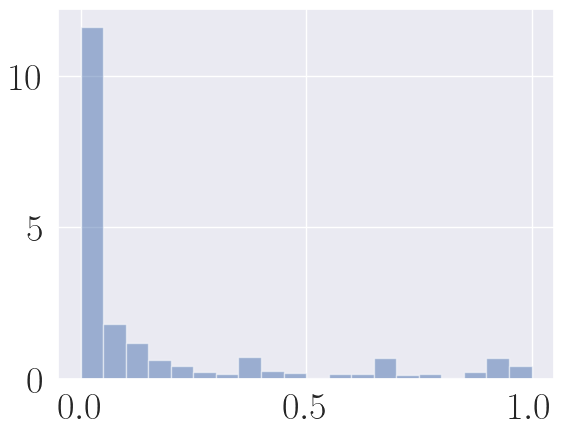

In [25]:
print(df_normalized['area_m'].shape)
df_normalized['area_m'].hist(  bins=20, density=True, alpha=0.5)

相关关系出图

In [ ]:
# sns.set_style("whitegrid") # 设置seaborn样式
# dataset = pd.concat([df_normalized.iloc[:,0:2],data_y['f1s_norm']],axis=1)
y = data_y['f1s_norm']
y=y.rename('f1')
# print(y.name)
dataset = pd.concat([df_normalized,y],axis=1)
dataset_std = pd.concat([df_normalized_std,y],axis=1)
dataset_mean= pd.concat([df_normalized_mean,y],axis=1)

print(dataset.shape)
def sactterplot(dataset,picname,x_vars,y_vars):
    g = sns.PairGrid(dataset,x_vars=x_vars,y_vars=y_vars )
    # g.map_upper(sns.regplot)
    # reg =sns.regplot(marker="*",line_kws={"color": "C1"})
    g.map_lower(qqplot)
    g.map_lower(generate_text)

    x_lim = (-0.2,1.1)
    y_lim = (-0.2,1.1)
    # g.map_upper(upper_regplot)
    g.set(xticks=[0,1], yticks=[0,1],xlim =x_lim,ylim=y_lim)
    # g.set(xticks=[0,1], yticks=[0,1] )
    g.map_upper(sns.kdeplot, levels=4, color=".2")
    g.map_upper(sns.scatterplot,s=8)
    # g.map_upper(sns.kdeplot)
    # g.map_upper(hexbin)
    # g.map_upper( sns.scatterplot, hue=None, levels=5, color=".2")
    # sns.displot(data=penguins, x="flipper_length_mm", kde=True)
    g.map_diag(sns.histplot,  bins=15)
    # g.map_upper(generate_text)
    g.tick_params(direction='out', labelsize = 'large' ,   grid_alpha=0.8)
    g.savefig(picname)
xvarall=['angle_m', 'angle_s', 'area_m', 'area_s', 'csd_m', 'csd_s', 'dis_m',
       'dis_s', 'per_m', 'per_s', 'zsc_m', 'zsc_s']
x_vars = []
xva_std=[name for name in xvarall if '_s' in name ]
xva_men=[name for name in xvarall if '_m' in name ]

yva_std=[name for name in xvarall if '_s' in name ] +['f1']
yva_men=[name for name in xvarall if '_m' in name ] +['f1']

picname ='ss_scatter_norm.png'
sactterplot(dataset,picname,xva_std,yva_std) 
print(picname,' complete')
picname ='mm_scatter_norm.png'
sactterplot(dataset,picname,xva_men,yva_men) 
print(picname,' complete')

picname ='sm_scatter_norm.png'
sactterplot(dataset,picname,xva_std,xva_men)
print(picname,' complete')

# g.set(   font_scale=2   )
# p=so.Plot(dataset_log).pair( y= ['precisions'],x=df_normalized_log.columns[0:2] )
# p=so.Plot(dataset).pair( y= ['precisions'],x=df_normalized.columns[0:1])
 
# for index,axs  in enumerate( g.axes )  :
#     for ax in axs:
#         print(index,ax.get_xlabel())
#         print(index,ax.get_ylabel())
#     break
# p.layout(size =(9,9))
# p .pair( y= ['precisions'],x=['area_mean'  ]  ) .layout(engine="tight")
# p .add(so.Dots())
# so.Plot(dataset["precisions"], dataset[df_normalized.columns[0 ]]).add(so.Bar())
# )b


 std 与f1之间的相关性

因子分析 kmo验证

In [1]:
chi_square_value,p_value=calculate_bartlett_sphericity(df_normalized)
chi_square_value, p_value  
# 计算KMO值 
kmo_all,kmo_model=calculate_kmo(df_normalized)
print(kmo_model)
# # 读取数据
# data = pd.read_csv('data.csv')

# # 初始化因子分析模型，并指定要提取的因子数量
# fa = FactorAnalyzer(n_factors=3)

# # 使用最大似然方法对数据进行因子分析
# fa.fit(data)

# # 输出因子载荷矩阵
# loadings = fa.loadings_
# print(loadings)

NameError: name 'calculate_bartlett_sphericity' is not defined

计算因子载荷

In [29]:
from factor_analyzer import FactorAnalyzer
import numpy as np
# 读取数据
# data = pd.read_csv('data.csv')

# 初始化因子分析模型，并使用最大似然方法对数据进行因子分析
fa = FactorAnalyzer(  n_factors=5, rotation='varimax')
fa.fit(df_normalized)
# 输出因子载荷矩阵
loadings = fa.loadings_
loadings[np.where(loadings<0.52)]=0.0
loadings =np.round(loadings,3)
loading_df =pd.DataFrame(loadings,index= df_normalized.columns)
loading_df.shape

(12, 5)

In [30]:
loading_df

,0,1,2,3,4
angle_m,0.802,0.521,0.000,0.000,0.000
angle_s,0.000,0.860,0.000,0.000,0.000
area_m,0.000,0.000,0.000,0.927,0.000
area_s,0.000,0.000,0.000,0.000,0.988
csd_m,0.000,0.000,0.820,0.000,0.000
csd_s,0.000,0.000,0.858,0.000,0.000
dis_m,0.882,0.000,0.000,0.000,0.000
dis_s,0.000,0.886,0.000,0.000,0.000
per_m,0.920,0.000,0.000,0.000,0.000
per_s,0.000,0.889,0.000,0.000,0.000


计算因子得分

In [ ]:
df_score = pd.DataFrame(fa.transform(df_normalized))
df_score##得到公因子
dataset_all = pd.concat([df_score,data_y['f1s_norm']],axis=1)
dataset_all.to_csv('score_factor.csv',index=False)


In [35]:
dataset_all 


,0,1,2,3,4,f1s_norm
0,6.035171,-2.907823,-1.755299,-2.604062,-4.361072,0.451423
1,6.106282,-2.897774,-1.799173,-2.644531,-4.375469,0.415303
2,6.154561,-2.990766,-1.764143,-2.608986,-4.342817,0.436324
3,6.158804,-3.129805,-1.721912,-2.506251,-4.317761,0.440437
4,6.171845,-3.019863,-1.755372,-2.567805,-4.307640,0.428147
...,...,...,...,...,...,...
10795,-1.976529,2.240060,0.224787,0.190922,-7.241791,0.493026
10796,-1.424303,1.039697,1.105403,1.104223,-5.744873,0.503362
10797,-0.360594,-1.284060,2.218452,2.253462,-3.986175,0.500425
10798,1.306840,-5.312971,5.062557,4.805549,0.737204,0.506204


计算累计方差矩阵

In [9]:

fa.get_factor_variance()

(array([3.84914474, 3.65995627, 1.87227449, 1.2124545 , 1.07459808,
        0.12345267]),
 array([0.32076206, 0.30499636, 0.15602287, 0.10103787, 0.08954984,
        0.01028772]),
 array([0.32076206, 0.62575842, 0.78178129, 0.88281917, 0.97236901,
        0.98265673]))

得到特征值ev、特征向量v

In [10]:
# 得到特征值ev、特征向量v
ev,v=fa.get_eigenvalues()
ev

array([7.50185504e+00, 1.51691552e+00, 1.28329556e+00, 8.81856838e-01,
       5.91151845e-01, 1.20640322e-01, 7.09542395e-02, 1.39205257e-02,
       7.09188108e-03, 6.23357706e-03, 4.32069233e-03, 1.76395533e-03])

In [51]:
v

array([ 7.48842212e+00,  1.22784474e+00,  9.96711220e-01,  4.78214541e-01,
        1.49675739e-01,  1.29348597e-02,  2.13791408e-03, -6.51173241e-03,
       -2.97086965e-02, -4.30665520e-02, -2.46582461e-01, -3.53188123e-01])

计算不包含area的因子

In [6]:
df_normalized.columns
name =['angle_m', 'angle_s',  'csd_m', 'csd_s', 'dis_m',
       'dis_s', 'per_m', 'per_s', 'zsc_m', 'zsc_s']
df_noarea = df_normalized[name]
df_noarea.columns

Index(['angle_m', 'angle_s', 'csd_m', 'csd_s', 'dis_m', 'dis_s', 'per_m',
       'per_s', 'zsc_m', 'zsc_s'],
      dtype='object')

In [7]:
# 因子分析检验
_,p_value=calculate_bartlett_sphericity(df_normalized)
print( p_value)  
# 计算KMO值 
_,kmo_model=calculate_kmo(df_normalized)
print(kmo_model)

0.0
0.7122173557400223


/home/dls/anaconda3/envs/pytorch2.0/lib/python3.10/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


In [14]:
from factor_analyzer import FactorAnalyzer
import numpy as np
# 读取数据
# data = pd.read_csv('data.csv')

# 初始化因子分析模型，并使用最大似然方法对数据进行因子分析
fa_noarea = FactorAnalyzer(  n_factors=5, rotation='varimax')
fa_noarea.fit(df_noarea)
# 输出因子载荷矩阵
loadings = fa_noarea.loadings_
loadings[np.where(loadings<0.5)]=0.0
loadings =np.round(loadings,3)
loading_df =pd.DataFrame(loadings,index= df_noarea.columns)
loading_df 

,0,1,2,3,4
angle_m,0.806,0.513,0.000,0.0,0.0
angle_s,0.000,0.879,0.000,0.0,0.0
csd_m,0.000,0.000,0.842,0.0,0.0
csd_s,0.000,0.000,0.905,0.0,0.0
dis_m,0.862,0.000,0.000,0.0,0.0
dis_s,0.000,0.861,0.000,0.0,0.0
per_m,0.909,0.000,0.000,0.0,0.0
per_s,0.000,0.880,0.000,0.0,0.0
zsc_m,0.923,0.000,0.000,0.0,0.0
zsc_s,0.000,0.779,0.000,0.0,0.0


In [11]:
fa_noarea.get_factor_variance()

(array([3.68950014, 3.64449147, 2.07996566, 0.26226281, 0.09568801]),
 array([0.36895001, 0.36444915, 0.20799657, 0.02622628, 0.0095688 ]),
 array([0.36895001, 0.73339916, 0.94139573, 0.96762201, 0.97719081]))

In [19]:
df_score_noarea = pd.DataFrame(fa_noarea.transform(df_noarea),columns=['fa1','fa2','fa3','fa4','fa5',])
df_score_noarea.columns##得到公因子


Index(['fa1', 'fa2', 'fa3', 'fa4', 'fa5'], dtype='object')

In [ ]:
dataset_all_noarea = pd.concat([df_score_noarea[['fa1','fa2','fa3']],data_y['f1s_norm']],axis=1)
dataset_all_noarea.to_csv('score_factor_noarea.csv',index=False)

计算带ir的 相关关系

In [6]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
# 计算巴特利特P值
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.preprocessing import MinMaxScaler
path = '/home/dls/data/openmmlab/test_RandomForestRegressor/large_samples_b60_all.csv'
# path ='/home/dls/data/openmmlab/test_RandomForestRegressor/processdata/FULLER4D_6_process.csv'
# path ='/home/dls/data/openmmlab/test_RandomForestRegressor/processdata/FULLER4H_6_process.csv'
# path ='/home/dls/data/openmmlab/test_RandomForestRegressor/processdata/FULLER4T_6_process.csv'
# path = '/home/dls/data/openmmlab/test_RandomForestRegressor/merge_nopre_test.csv'
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
data = pd.read_csv(path)
data_y=['recalls',
 'recalls_norm',
 'accs',
 'accs_norm',
 'f1s',
 'f1s_norm',
 'precisions',
 'precisions_norm']
x_name = [name for name in data.columns if name not in data_y]
data_x =  data[x_name]
data_y =  data[data_y]
# print(data_x.head())
# print(data_y.head())

# need_name = ['area','per','zsc','disminmax','disavg','angleminmax','angleavg','csdminmax','csdavg','precisions' ]
# data =data[need_name]
# 将数据集分成训练集和测试集 最后一列是因变量 剩余的列是自变量
scaler = MinMaxScaler() #为了使用同一个归一化器 先归一化 再分割
df_normalized_ir = pd.DataFrame(scaler.fit_transform(data_x), columns=data_x.columns)
# df_normalized.head()

corr = data_x.corrwith(data_y['f1s_norm'] )
with open('/home/dls/data/openmmlab/test_RandomForestRegressor/log_x_norm_ir.txt','w') as f :
    ind =corr.index.str.contains('_ir')
    # out =corr[ind]
    # ind1 = out.index.str.contains('norm')
    # out =out[~ind1]
    f.write(
        f'Correlation between data_x and f1s_norm :\n{corr[ind]}\n'
    )

# 发现norm完后的结果普遍变好 利用spherephd处理的结果没有普通的好

corr1 = df_normalized_ir.corrwith(data_y['f1s_norm'] )
with open('/home/dls/data/openmmlab/test_RandomForestRegressor/log_norm_norm_ir.txt','w') as f :
    ind =corr1.index.str.contains('_ir')
    # out =corr[ind]
    # ind1 = out.index.str.contains('norm')
    # out =out[ind1]
    f.write(
        f'Correlation between df_normalized and f1s_norm :\n{corr1[ind]}\n'
    )
namefilter =[name for name in df_normalized_ir.columns if (('norm' not in name) and ('_ir' in name)) ]
print('namefilter',namefilter)
df_normalized_ir = df_normalized_ir[namefilter]##loc 去除方差行 选择多列和多行

namefilter ['angle_irmean', 'angle_irstd', 'area_irmean', 'area_irstd', 'csd_irmean', 'csd_irstd', 'dis_irmean', 'dis_irstd', 'per_irmean', 'per_irstd', 'zsc_irmean', 'zsc_irstd']


In [10]:
# dataset = pd.concat([df_normalized.iloc[:,0:2],data_y['f1s_norm']],axis=1)

# newcolumns = []
df_normalized_mean = pd.DataFrame()
df_normalized_std = pd.DataFrame()

for name ,value in df_normalized_ir.items():
    # print(name)
    if 'std'in name :
        base=name.split('_')[0]
        newname = base+'_s'
        df_normalized_std[newname] =value
    elif 'mean'in name :
        base=name.split('_')[0]
        newname = base+'_m'
        df_normalized_mean[newname] =value
    else:
        raise(f'name is {name}')
 
# print('df_normalized_ir.columns',df_normalized_ir.columns)
print('df_normalized_mean.columns',df_normalized_mean.columns)
print('df_normalized_std.columns',df_normalized_std.columns)

 

df_normalized_mean.columns Index(['angle_m', 'area_m', 'csd_m', 'dis_m', 'per_m', 'zsc_m'], dtype='object')
df_normalized_std.columns Index(['angle_s', 'area_s', 'csd_s', 'dis_s', 'per_s', 'zsc_s'], dtype='object')


### 相关关系出图

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# sns.set_style("whitegrid") # 设置seaborn样式
plt.rc('text', usetex=True) # 启用LaTeX
plt.rc('font', family='sans-serif') # 设置LaTeX字体
sns.set(  font_scale=2.5 )

dataset = pd.concat([df_normalized_mean,data_y['f1s_norm']],axis=1)
def qqplot (x, y, **kwargs):
   regax =sns.regplot(x=x,y=y,line_kws={"color": "k","linewidth": 0.8, "linestyle": "--"}, scatter_kws={"s": 2   })##,marker="*" , "color": "k"
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=25, cmap=cmap, **kwargs)
def upper_regplot(x, y, **kwargs):
      scaax =sns.kdeplot(x=x,y=y  )
def generate_text(x,y, **kwargs):
      scaax = plt.gca()
      x_lim = (-0.05,1.1)
      x_range = scaax.get_xlim()[1] - scaax.get_xlim()[0]
      y_range = scaax.get_ylim()[1] - scaax.get_ylim()[0]
      value = round(abs(x.corr(y)), 2)
      if value >0.3:
            color='r'
            fontweight='heavy'
      else:
            color=None
            fontweight='normal'

      text = r"$\rho$"+  f"={round(x.corr(y), 2)}"
      # plt.gca().set_color(p1.get_color())
      plt.text(x_lim[1]*0.65 ,x_lim[1]*0.65 , text, ha='center', va='center',fontsize =30,color=color,fontweight=fontweight)
g = sns.PairGrid(dataset )
g.map_lower(qqplot)
g.map_lower(generate_text)
x_lim = (-0.2,1.1)
y_lim = (-0.2,1.1)
g.set(xticks=[0,1], yticks=[0,1],xlim =x_lim,ylim=y_lim)
g.map_upper(sns.kdeplot, levels=4, color=".2")
g.map_upper(sns.scatterplot,s=8)
 
g.map_diag(sns.histplot,  bins=15)
# g.map_upper(generate_text)
g.tick_params(direction='out', labelsize = 'large' ,   grid_alpha=0.8)
# g.savefig('./scatter.png')
 


In [ ]:
dataset_std = pd.concat([df_normalized_std,data_y['f1s_norm']],axis=1)
g_std = sns.PairGrid(dataset_std )
g_std.map_lower(qqplot)
g_std.map_lower(generate_text)
x_lim = (-0.2,1.1)
y_lim = (-0.2,1.1)
g_std.set(xticks=[0,1], yticks=[0,1],xlim =x_lim,ylim=y_lim)
g_std.map_upper(sns.kdeplot, levels=4, color=".2")
g_std.map_upper(sns.scatterplot,s=8)
 
g_std.map_diag(sns.histplot,  bins=15)
# g.map_upper(generate_text)
g_std.tick_params(direction='out', labelsize = 'large' ,   grid_alpha=0.8)